# Q 学习


In [ ]:
from dataclasses import dataclass
import gym
import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
@dataclass
class Config:
    lr: float = 0.1
    gamma: float = 0.99
    epsilon: float = 1.0
    epsilon_max: float = 1.0
    epsilon_min: float = 0.01
    epsilon_decay: float = 3e-4
    epochs: int = 500

class QLearning:
    def __init__(self, env, cfg):
        self.env = env
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.lr = cfg.lr
        self.gamma = cfg.gamma
        self.epsilon = cfg.epsilon
        self.epsilon_max = cfg.epsilon_max
        self.epsilon_min = cfg.epsilon_min
        self.epsilon_decay = cfg.epsilon_decay
        self.samplt_cnt = 0
        self.Q_table = {str(s): np.zeros(self.n_actions) for s in range(self.n_states)}

    def choose_action(self, state):
        self.samplt_cnt += 1
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * \
                       math.exp(-1. * self.samplt_cnt * self.epsilon_decay)

        if np.random.uniform() > self.epsilon:
            action = np.argmax(self.Q_table[str(state)])
        else:
            action = np.random.choice(self.n_actions)
        return action
    
    def learn(self, state, action, reward, terminated, next_state):
        if terminated:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)])

        Q_predict = self.Q_table[str(state)][action]
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)


In [ ]:
env = gym.make('CliffWalking-v0')
cfg = Config()
agent = QLearning(env, cfg)

def train(env):
    ep_rewards, ma_rewards = [], [] # 每回合奖励 and 滑动平均奖励

    for i in range(cfg.epochs):
        state, _ = env.reset()
        ep_reward = 0
        terminated = False

        while not terminated:
            action = agent.choose_action(state)
            next_state, reward, terminated, *_ = env.step(action)
            agent.learn(state, action, reward, terminated, next_state)
            state = next_state
            ep_reward += reward
        
        ep_rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
        
        if (i + 1) % 50 == 0:
            print(f'Episode {i+1}, Reward: {ep_reward}, Epsilon: {agent.epsilon}')
    
    plt.plot(ep_rewards, label='Episode Reward')
    plt.plot(ma_rewards, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

In [ ]:
train(env)

In [ ]:
def real_play(env, agent, max_step):
    state, _ = env.reset()
    terminated = False
    step_cnt = 0

    while not terminated and step_cnt < max_step:
        action = np.argmax(agent.Q_table[str(state)])
        next_state, _, terminated, truncated, _ = env.step(action)
        state = next_state
        terminated = terminated | truncated
        step_cnt += 1
    
    print(f"Episode finished after {step_cnt} steps.")
    env.close()

In [ ]:
env = gym.make('CliffWalking-v0', render_mode="human")
real_play(env, agent, 100)

# DQN

In [1]:
from torch import nn
import math
import gym
import torch
from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [2]:
@dataclass
class Config:
    lr: float = 3e-4
    gamma: float = 0.99
    epsilon: float = 1.0
    epsilon_max: float = 1.0
    epsilon_min: float = 0.01
    epsilon_decay: float = 3e-4
    epochs: int = 300
    memory_size: int = 10000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    n_hiddens = 256
    n_outputs = 2
    target_update = 10


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, terminated):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        
        self.buffer[self.position] = (state, action, reward, next_state, terminated)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)
    
    def __len__(self):
        return len(self.buffer)


class MLP(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DQN:
    def __init__(self, cfg):
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.batch_size = cfg.batch_size
        self.action_space = env.action_space.n
        self.frame_idx = 0

        self.policy_net = MLP(4, cfg.n_hiddens, cfg.n_outputs).to(cfg.device)
        self.target_net = MLP(4, cfg.n_hiddens, cfg.n_outputs).to(cfg.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_size)

        self.epsilon_max = 1.
        self.epsilon_min = 0.01
        self.epsilon_decay = 3e-4

    def epsilon(self, frame_idx):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) \
            * math.exp(-1. * frame_idx / self.epsilon_decay)
    
    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_space)
        return action
    
    def learn(self):
        if len(self.memory) < self.batch_size: return

        state_batch, action_batch, reward_batch, next_batch, terminated_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, device=self.device, dtype=torch.long).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float32)
        next_batch = torch.tensor(next_batch, device=self.device, dtype=torch.float32)
        terminated_batch = torch.tensor(terminated_batch, device=self.device, dtype=torch.float32)

        q_values = self.policy_net(state_batch).gather(1, index=action_batch)
        next_q_values = self.target_net(next_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - terminated_batch)

        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


In [3]:
def train(env):
    rewards, ma_rewards = [], [] # 每回合奖励 and 滑动平均奖励

    for i in range(cfg.epochs):
        state, _ = env.reset()
        ep_reward = 0
        terminated = False

        while not terminated:
            action = agent.choose_action(state)
            next_state, reward, terminated, *_ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, terminated)
            state = next_state
            agent.learn()

            if terminated: break
        
        if (i + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i + 1) % 10 == 0:
            print('回合: {}/{}, 奖励: {}'.format(i+1, cfg.epochs, ep_reward))

        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
    
    plt.plot(ma_rewards, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

d:\Here\Python3.10\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\Abyss\AppData\Local\Temp\ipykernel_20352\2328697567.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  state = torch.tensor([state], device=self.device, dtype=torch.float32)


回合: 10/300, 奖励: 9.0
回合: 20/300, 奖励: 10.0
回合: 30/300, 奖励: 9.0
回合: 40/300, 奖励: 9.0
回合: 50/300, 奖励: 9.0
回合: 60/300, 奖励: 10.0
回合: 70/300, 奖励: 10.0
回合: 80/300, 奖励: 10.0
回合: 90/300, 奖励: 11.0
回合: 100/300, 奖励: 14.0
回合: 110/300, 奖励: 9.0
回合: 120/300, 奖励: 22.0
回合: 130/300, 奖励: 32.0
回合: 140/300, 奖励: 41.0
回合: 150/300, 奖励: 78.0
回合: 160/300, 奖励: 124.0
回合: 170/300, 奖励: 134.0
回合: 180/300, 奖励: 140.0
回合: 190/300, 奖励: 148.0
回合: 200/300, 奖励: 128.0
回合: 210/300, 奖励: 119.0
回合: 220/300, 奖励: 123.0
回合: 230/300, 奖励: 171.0
回合: 240/300, 奖励: 128.0
回合: 250/300, 奖励: 204.0
回合: 260/300, 奖励: 170.0
回合: 270/300, 奖励: 268.0
回合: 280/300, 奖励: 235.0
回合: 290/300, 奖励: 265.0
回合: 300/300, 奖励: 196.0


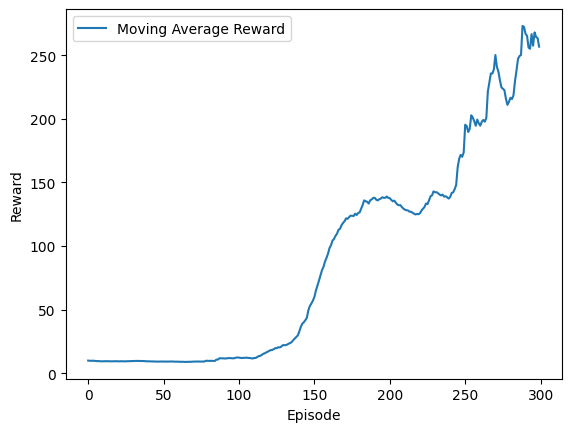

In [4]:
env = gym.make('CartPole-v1')
cfg = Config()
agent = DQN(cfg)

train(env)

In [ ]:
def test_policy(env, policy_net, device, episodes=5, render=True):
    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()

            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.argmax(1).item()

            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else (*env.step(action), False)
            total_reward += reward
            state = next_state

        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()


env = gym.make('CartPole-v0', render_mode="human")
test_policy(env, agent.policy_net, cfg.device, episodes=5, render=True)


d:\Here\Python3.10\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
d:\Here\Python3.10\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Episode 1: Total Reward = 163.0
Episode 2: Total Reward = 791.0
Episode 3: Total Reward = 201.0
Episode 4: Total Reward = 311.0
Episode 5: Total Reward = 257.0
Episode 6: Total Reward = 277.0


In [ ]:
import numpy as np


def test_policy(env, policy_net, device, episodes=5, render=True):
    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # 兼容新版本 Gym
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()

            # 用 policy_net 选择最优动作（不加 ε-greedy 探索）
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.argmax(1).item()

            # 执行动作
            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else (*env.step(action), False)
            total_reward += reward
            state = next_state

        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()


env = gym.make('CartPole-v0', render_mode="human")
test_policy(env, agent.policy_net, cfg.device, episodes=5, render=True)


In [ ]:
import gym
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass


@dataclass
class Config:
    lr: float = 1e-3
    gamma: float = 0.99
    epsilon: float = 1.0
    epsilon_max: float = 1.0
    epsilon_min: float = 0.01
    epsilon_decay: float = 3e-4
    epochs: int = 300
    memory_size: int = 10000
    device = torch.device("cuda")
    batch_size = 64

    n_hiddens = 128
    n_inputs = 4
    n_outputs = 2
    
    target_update = 10


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, terminated):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, terminated)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return list(zip(*batch))  # important for unpacking

    def __len__(self):
        return len(self.buffer)


class MLP(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DQN:
    def __init__(self, cfg):
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.batch_size = cfg.batch_size
        self.action_space = cfg.n_outputs
        self.frame_idx = 0

        self.policy_net = MLP(cfg.n_inputs, cfg.n_hiddens, cfg.n_outputs).to(cfg.device)
        self.target_net = MLP(cfg.n_inputs, cfg.n_hiddens, cfg.n_outputs).to(cfg.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_size)

        self.epsilon_max = cfg.epsilon_max
        self.epsilon_min = cfg.epsilon_min
        self.epsilon_decay = cfg.epsilon_decay

    def epsilon(self, frame_idx):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) \
            * math.exp(-1. * frame_idx * self.epsilon_decay)

    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_space)
        return action

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        state_batch, action_batch, reward_batch, next_batch, terminated_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, device=self.device, dtype=torch.long).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float32)
        next_batch = torch.tensor(next_batch, device=self.device, dtype=torch.float32)
        terminated_batch = torch.tensor(terminated_batch, device=self.device, dtype=torch.float32)

        q_values = self.policy_net(state_batch).gather(1, action_batch)
        next_q_values = self.target_net(next_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - terminated_batch)

        loss = nn.MSELoss()(q_values.squeeze(), expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


def train(env, agent, cfg):
    rewards, ma_rewards = [], []

    for i in range(cfg.epochs):
        state, _ = env.reset()
        ep_reward = 0
        terminated = False

        while not terminated:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, terminated or truncated)
            state = next_state
            agent.learn()

        if (i + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if (i + 1) % 10 == 0:
            print(f'回合: {i+1}/{cfg.epochs}, 奖励: {ep_reward:.2f}')

        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)

    plt.plot(ma_rewards, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("DQN on CartPole-v0")
    plt.legend()
    plt.show()


# =============
env = gym.make('CartPole-v0', render_mode=None)
cfg = Config()
agent = DQN(cfg)
train(env, agent, cfg)


In [ ]:
import numpy as np


def test_policy(env, policy_net, device, episodes=5, render=True):
    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # 兼容新版本 Gym
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()

            # 用 policy_net 选择最优动作（不加 ε-greedy 探索）
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.argmax(1).item()

            # 执行动作
            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else (*env.step(action), False)
            total_reward += reward
            state = next_state

        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()


env = gym.make('CartPole-v0', render_mode="human")
test_policy(env, agent.policy_net, cfg.device, episodes=5, render=True)


In [ ]:
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass

import gym
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import torch

In [ ]:
@dataclass
class Config:
    n_states: int = 4
    n_actions: int = 2
    n_hiddens: int = 256

    lr: float = 0.0007
    gamma: float = 0.99
    epsilon_max: float = 1.0
    epsilon_min: float = 0.01
    epsilon_decay: float = 3e-4

    batch_size: int = 128
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    target_update: int = 10
    memory_size: int = 10000
    epochs: int = 300


class TriMLP(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = [None] * cfg.memory_size
        self.position = 0
        self.size = 0

    def push(self, state, action, reward, next_state, done):
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer[:self.size], batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.tensor(states, dtype=torch.float32, device=cfg.device),
                torch.tensor(actions, dtype=torch.long, device=cfg.device).unsqueeze(1),
                torch.tensor(rewards, dtype=torch.float32, device=cfg.device),
                torch.tensor(next_states, dtype=torch.float32, device=cfg.device),
                torch.tensor(dones, dtype=torch.float32, device=cfg.device))

    def __len__(self):
        return self.size


class DQN:
    def __init__(self, cfg):
        self.policy_net = TriMLP(cfg.n_states, cfg.n_hiddens, cfg.n_actions).to(cfg.device)
        self.target_net = TriMLP(cfg.n_states, cfg.n_hiddens, cfg.n_actions).to(cfg.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.memory = ReplayBuffer(cfg.memory_size)

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.loss = nn.MSELoss()

        self.frame_idx = 0
        self.cfg = cfg
    
    def choose_action(self, state):
        state = torch.tensor([state], dtype=torch.float32, device=self.cfg.device)
        if state.ndim == 1:
            state = state.unsqueeze(0)
            
        self.frame_idx += 1
        if random.random() > self.epsilon():
            q_value = self.policy_net(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randint(0, self.cfg.n_actions - 1)
        return action
    
    def learn(self):
        if len(self.memory) < self.cfg.batch_size: return
        states, actions, rewards, next_states, dones = self.memory.sample(self.cfg.batch_size)

        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.cfg.gamma * next_q_values * (1 - dones)

        loss = self.loss(q_values.squeeze(), expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def epsilon(self):
        return self.cfg.epsilon_min + (self.cfg.epsilon_max - self.cfg.epsilon_min) * \
            math.exp(-self.frame_idx * self.cfg.epsilon_decay)

In [ ]:

def train(env, agent, cfg):
    rewards, ma_rewards = [], []

    for i in range(cfg.epochs):
        state, _ = env.reset()
        ep_reward = 0
        terminated = False

        while not terminated:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, terminated or truncated)
            state = next_state
            agent.learn()

        if (i + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if (i + 1) % 10 == 0:
            print(f'回合: {i+1}/{cfg.epochs}, 奖励: {ep_reward:.2f}')

        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)

    plt.plot(ma_rewards, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title("DQN on CartPole-v0")
    plt.legend()
    plt.show()


env = gym.make('CartPole-v0', render_mode=None)
cfg = Config()
agent = DQN(cfg)
train(env, agent, cfg)

In [ ]:
def test_policy(env, policy_net, device, episodes=5, render=True):
    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # 兼容新版本 Gym
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()

            # 用 policy_net 选择最优动作（不加 ε-greedy 探索）
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.argmax(1).item()

            # 执行动作
            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else (*env.step(action), False)
            total_reward += reward
            state = next_state

        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()


env = gym.make('CartPole-v0', render_mode="human")
test_policy(env, agent.policy_net, cfg.device, episodes=5, render=True)


In [ ]:
from torch import nn
import math
import gym
import torch
from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [ ]:
@dataclass
class Config:
    lr: float = 3e-4
    gamma: float = 0.99
    epsilon: float = 1.0
    epsilon_max: float = 1.0
    epsilon_min: float = 0.01
    epsilon_decay: float = 3e-4
    epochs: int = 300
    memory_size: int = 10000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    n_hiddens = 256
    n_outputs = 2
    target_update = 10


# class ReplayBuffer:
#     def __init__(self, capacity):
#         self.capacity = capacity
#         self.buffer = []
#         self.position = 0

#     def push(self, state, action, reward, next_state, terminated):
#         if len(self.buffer) < self.capacity:
#             self.buffer.append(None)
        
#         self.buffer[self.position] = (state, action, reward, next_state, terminated)
#         self.position = (self.position + 1) % self.capacity

#     def sample(self, batch_size):
#         batch = random.sample(self.buffer, batch_size)
#         return zip(*batch)
    
#     def __len__(self):
#         return len(self.buffer)
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = [None] * cfg.memory_size
        self.position = 0
        self.size = 0

    def push(self, state, action, reward, next_state, done):
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer[:self.size], batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.tensor(states, dtype=torch.float32, device=cfg.device),
                torch.tensor(actions, dtype=torch.long, device=cfg.device),
                # torch.tensor(actions, dtype=torch.long, device=cfg.device).unsqueeze(1),
                torch.tensor(rewards, dtype=torch.float32, device=cfg.device),
                torch.tensor(next_states, dtype=torch.float32, device=cfg.device),
                torch.tensor(dones, dtype=torch.float32, device=cfg.device))

    def __len__(self):
        return self.size

class MLP(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DQN:
    def __init__(self, cfg):
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.batch_size = cfg.batch_size
        self.action_space = env.action_space.n
        self.frame_idx = 0

        self.policy_net = MLP(4, cfg.n_hiddens, cfg.n_outputs).to(cfg.device)
        self.target_net = MLP(4, cfg.n_hiddens, cfg.n_outputs).to(cfg.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_size)

        self.epsilon_max = 1.
        self.epsilon_min = 0.01
        self.epsilon_decay = 3e-4

    def epsilon(self):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) \
            * math.exp(-1. * self.frame_idx / self.epsilon_decay)
    
    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon():
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_space)
        return action
    
    def learn(self):
        if len(self.memory) < self.batch_size: return

        state_batch, action_batch, reward_batch, next_batch, terminated_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(state_batch, device=self.device, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, device=self.device, dtype=torch.long).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float32)
        next_batch = torch.tensor(next_batch, device=self.device, dtype=torch.float32)
        terminated_batch = torch.tensor(terminated_batch, device=self.device, dtype=torch.float32)

        q_values = self.policy_net(state_batch).gather(1, index=action_batch)
        next_q_values = self.target_net(next_batch).max(1)[0].detach()
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - terminated_batch)

        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


def train(env):
    rewards, ma_rewards = [], [] # 每回合奖励 and 滑动平均奖励

    for i in range(cfg.epochs):
        state, _ = env.reset()
        ep_reward = 0
        terminated = False

        while not terminated:
            action = agent.choose_action(state)
            next_state, reward, terminated, *_ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, terminated)
            state = next_state
            agent.learn()

            if terminated: break
        
        if (i + 1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i + 1) % 10 == 0:
            print('回合: {}/{}, 奖励: {}'.format(i+1, cfg.epochs, ep_reward))

        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
    
    plt.plot(ma_rewards, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

env = gym.make('CartPole-v0')
cfg = Config()
agent = DQN(cfg)

train(env)

In [ ]:
def test_policy(env, policy_net, device, episodes=5, render=True):
    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # 兼容新版本 Gym
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()

            # 用 policy_net 选择最优动作（不加 ε-greedy 探索）
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.argmax(1).item()

            # 执行动作
            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else (*env.step(action), False)
            total_reward += reward
            state = next_state

        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()


env = gym.make('CartPole-v0', render_mode="human")
test_policy(env, agent.policy_net, cfg.device, episodes=5, render=True)


In [1]:
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass

import gym
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [ ]:
@dataclass
class Config:
    n_states: int = 4
    n_actions: int = 2
    n_hiddens: int = 128

    lr = 0.001
    gamma = 0.99
    epsilon_max: float = 1.0
    epsilon_min: float = 0.01
    epsilon_decay: float = 3e-4

    batch_size: int = 64
    target_update_interval: int = 10
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    memory_size: int = 10000
    epochs: int = 500


class TriMLP(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_hiddens)
        self.fc3 = nn.Linear(n_hiddens, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    def __init__(self, capacity, device):
        self.capacity = capacity
        self.buffer = [None] * capacity
        self.position = 0
        self.size = 0
        self.device = device
    
    def push(self, state, action, reward, next_state, done):
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer[:self.size], batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.tensor(states, dtype=torch.float32, device=self.device),
                torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1),
                torch.tensor(rewards, dtype=torch.float32, device=self.device),
                torch.tensor(next_states, dtype=torch.float32, device=self.device),
                torch.tensor(dones, dtype=torch.float32, device=self.device))
    
    def __len__(self):
        return self.size


class DQN:
    def __init__(self, cfg):
        self.policy_net = TriMLP(cfg.n_states, cfg.n_hiddens, cfg.n_actions).to(cfg.device)
        self.target_net = TriMLP(cfg.n_states, cfg.n_hiddens, cfg.n_actions).to(cfg.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.memory = ReplayBuffer(cfg.memory_size, cfg.device)

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.loss = nn.MSELoss()

        self.frame_idx = 0
        self.cfg = cfg
    
    def choose_action(self, state):
        self.frame_idx += 1
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor([state], dtype=torch.float32, device=self.cfg.device)
                # if state.dim() == 1:
                #     state = state.unsqueeze(0)
                q_value = self.policy_net(state)
                action = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.cfg.n_actions)
        return action
    
    def learn(self):
        if len(self.memory) < self.cfg.batch_size: return
        states, actions, rewards, next_states, dones = self.memory.sample(self.cfg.batch_size)

        q_values = self.policy_net(states).gather(1, actions) # dim 2
        next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.cfg.gamma * next_q_values * (1 - dones)
    
        loss = self.loss(q_values.squeeze(), expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        # wait advancement
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    @property
    def epsilon(self):
        return self.cfg.epsilon_min + (self.cfg.epsilon_max - self.cfg.epsilon_min) * \
            math.exp(-self.frame_idx * self.cfg.epsilon_decay)


def train(agent, env, cfg):
    rewards, ma_rewards = [], []

    for i in range(cfg.epochs):
        state, _ = env.reset()
        ep_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            # agent.memory.push(state, action, reward, next_state, done or truncated)
            state = next_state
            agent.learn()
            
            if done or truncated:
                break
        
        if (i + 1) % cfg.target_update_interval == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i + 1) % 10 == 0:
            print(f'回合: {i+1}/{cfg.epochs}, 奖励: {ep_reward}')
        
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
        
    plt.plot(ma_rewards, label='Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()


回合: 10/500, 奖励: 20.0
回合: 20/500, 奖励: 17.0
回合: 30/500, 奖励: 15.0
回合: 40/500, 奖励: 10.0
回合: 50/500, 奖励: 25.0
回合: 60/500, 奖励: 94.0
回合: 70/500, 奖励: 44.0
回合: 80/500, 奖励: 69.0
回合: 90/500, 奖励: 103.0
回合: 100/500, 奖励: 184.0
回合: 110/500, 奖励: 200.0
回合: 120/500, 奖励: 187.0
回合: 130/500, 奖励: 121.0
回合: 140/500, 奖励: 152.0
回合: 150/500, 奖励: 102.0
回合: 160/500, 奖励: 118.0
回合: 170/500, 奖励: 250.0
回合: 180/500, 奖励: 134.0
回合: 190/500, 奖励: 252.0
回合: 200/500, 奖励: 137.0
回合: 210/500, 奖励: 121.0
回合: 220/500, 奖励: 113.0
回合: 230/500, 奖励: 110.0
回合: 240/500, 奖励: 118.0
回合: 250/500, 奖励: 124.0
回合: 260/500, 奖励: 130.0
回合: 270/500, 奖励: 123.0
回合: 280/500, 奖励: 275.0
回合: 290/500, 奖励: 168.0
回合: 300/500, 奖励: 197.0
回合: 310/500, 奖励: 162.0
回合: 320/500, 奖励: 212.0
回合: 330/500, 奖励: 282.0
回合: 340/500, 奖励: 148.0
回合: 350/500, 奖励: 161.0
回合: 360/500, 奖励: 415.0
回合: 370/500, 奖励: 279.0
回合: 380/500, 奖励: 185.0
回合: 390/500, 奖励: 209.0
回合: 400/500, 奖励: 255.0
回合: 410/500, 奖励: 304.0
回合: 420/500, 奖励: 264.0
回合: 430/500, 奖励: 381.0
回合: 440/500, 奖励: 357.0
回合: 4

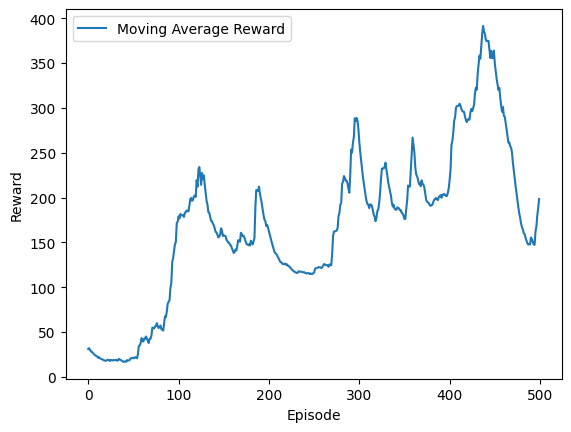

In [17]:
env = gym.make('CartPole-v1')
cfg = Config()
agent = DQN(cfg)

train(agent, env, cfg)

In [18]:
def test_policy(env, policy_net, device, episodes=5, render=True):
    for ep in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # 兼容新版本 Gym
            state = state[0]
        done = False
        total_reward = 0
        while not done:
            if render:
                env.render()

            # 用 policy_net 选择最优动作（不加 ε-greedy 探索）
            state_tensor = torch.tensor([state], device=device, dtype=torch.float32)
            with torch.no_grad():
                q_values = policy_net(state_tensor)
                action = q_values.argmax(1).item()

            # 执行动作
            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else (*env.step(action), False)
            total_reward += reward
            state = next_state

        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()


env = gym.make('CartPole-v0', render_mode="human")
test_policy(env, agent.policy_net, cfg.device, episodes=5, render=True)


Episode 1: Total Reward = 71.0
Episode 2: Total Reward = 60.0
Episode 3: Total Reward = 61.0
Episode 4: Total Reward = 66.0
Episode 5: Total Reward = 65.0
